In [32]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from sklearn.feature_extraction.text import TfidfVectorizer
from keras import Sequential
from keras.layers import GRU, Embedding, Dense
from keras.callbacks import EarlyStopping
from keras.metrics import AUC
from tensorflow.keras.optimizers.legacy import Adam

In [2]:
#import train
train = pd.read_csv('train.csv')
train = train.replace(np.nan, '', regex=True)
#import test
test = pd.read_csv('test.csv')
#import sample submission
samp = pd.read_csv('sample_submission.csv')

In [3]:
#EDA
print(train.info())
print(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7613 non-null   object
 2   location  7613 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
   id keyword location                                               text  \
0   1                   Our Deeds are the Reason of this #earthquake M...   
1   4                              Forest fire near La Ronge Sask. Canada   
2   5                   All residents asked to 'shelter in place' are ...   
3   6                   13,000 people receive #wildfires evacuation or...   
4   7                   Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


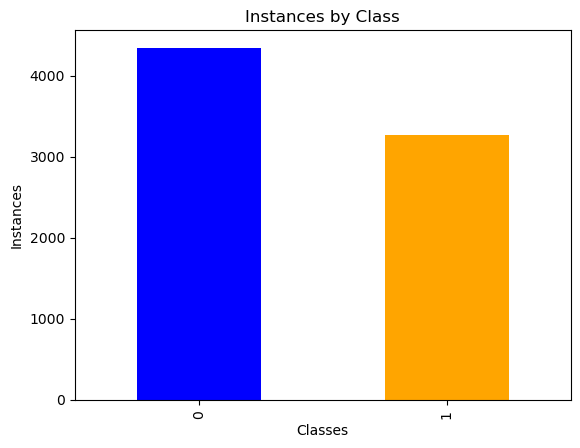

In [4]:
#Instances By Class
train['target'].value_counts().plot(kind = 'bar', color = ['blue', 'orange'])
plt.title('Instances by Class')
plt.xlabel('Classes')
plt.ylabel('Instances')
plt.show()

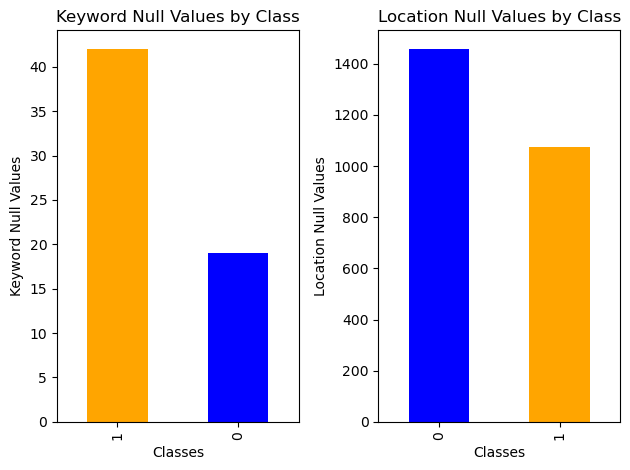

In [5]:
#Charts for null values in keyword and location by class
plt.subplot(1, 2, 1)
train['target'][train['keyword'] == ''].value_counts().plot(kind = 'bar', color = ['orange', 'blue'])
plt.title('Keyword Null Values by Class')
plt.xlabel('Classes')
plt.ylabel('Keyword Null Values')
plt.subplot(1, 2, 2)
train['target'][train['location'] == ''].value_counts().plot(kind = 'bar', color = ['blue', 'orange'])
plt.title('Location Null Values by Class')
plt.xlabel('Classes')
plt.ylabel('Location Null Values')
plt.tight_layout()
plt.show()

In [41]:
##Data Preprocessing
#removing what is not word sentence or number in text 
train['text'] = train['text'].str.replace(r'[^\w\s]+', '', regex = True)
#removing URLs
train['text'] = train['text'].str.replace(r'https?://(www\.)?(\w+)(\.\w+)(/\w*)?', '', regex = True)
#removing words with numbers
train['text'] = train['text'].str.replace(r'\w*\d\w*', '', regex= True)

#making all words lowercase
train['text'] = train['text'].apply(lambda x: x.lower())

#removing html tags with Beautiful Soup
def html_remove(x):
    return BeautifulSoup(x, 'lxml').get_text()
train['text'] = train['text'].apply(lambda x: html_remove(x))

#Removing stop words
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens_no_stop = [i for i in tokens if i not in stop_words]
    tokens_filtered = (' ').join(tokens_no_stop)
    return tokens_filtered
train['text'] = train['text'].apply(lambda x: remove_stopwords(x))


###Test Data
#removing what is not word sentence or number in text 
test['text'] = test['text'].str.replace(r'[^\w\s]+', '', regex = True)
#removing URLs
test['text'] = test['text'].str.replace(r'https?://(www\.)?(\w+)(\.\w+)(/\w*)?', '', regex = True)
#removing words with numbers
test['text'] = test['text'].str.replace(r'\w*\d\w*', '', regex= True)

#making all words lowercase
test['text'] = test['text'].apply(lambda x: x.lower())

#removing html tags with Beautiful Soup
def html_remove(x):
    return BeautifulSoup(x, 'lxml').get_text()
test['text'] = test['text'].apply(lambda x: html_remove(x))

#Removing stop words
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens_no_stop = [i for i in tokens if i not in stop_words]
    tokens_filtered = (' ').join(tokens_no_stop)
    return tokens_filtered
test['text'] = test['text'].apply(lambda x: remove_stopwords(x))


In [39]:
#Tokenizing Text train data
#source: https://medium.datadriveninvestor.com/padding-used-in-nlp-are-they-improvers-2f4613bd3648
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(train['text'])
word_index = tokenizer.word_index
vocab_size = len(list(word_index.keys())) + 1
sequences = tokenizer.texts_to_sequences(train['text'])
padded_sequences = pad_sequences(sequences, padding='post', truncating='post', maxlen=20)
# print(padded_sequences)


#Tokenizing Text test
sequences_test = tokenizer.texts_to_sequences(test['text'])
padded_sequences_test = pad_sequences(sequences_test, padding='post', truncating='post', maxlen=20)

In [24]:
print(padded_sequences.shape)
print(padded_sequences_test.shape)

(7613, 20)
(3263, 20)


In [9]:
len(list(word_index.keys()))

17335

In [33]:
#getting X and y
X = train['text']
y = train['target']

le = LabelEncoder()
y = le.fit_transform(y)
y = y.reshape(-1,1)
# #splitting into training and validation set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [30]:
vocab_size = len(list(word_index.keys())) + 1
#model
model = Sequential([
    Embedding(vocab_size, 64, input_length=padded_sequences.shape[1]),
    GRU(64),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

# ROC = AUC()

opt = Adam(
    learning_rate = 0.0001,
    amsgrad = True
)
model.compile(
    optimizer = opt,
    loss='binary_crossentropy',
    metrics = ['accuracy']
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 20, 64)            1109504   
                                                                 
 gru_6 (GRU)                 (None, 64)                24960     
                                                                 
 dense_12 (Dense)            (None, 16)                1040      
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,135,521
Trainable params: 1,135,521
Non-trainable params: 0
_________________________________________________________________


In [35]:
callback = EarlyStopping(patience = 3)
model.fit(
    padded_sequences, 
    y, 
    validation_split=0.2, 
    epochs = 15, 
    batch_size=3,
    callbacks=[callback]
)

Epoch 1/15
2030/2030 [==============================] - 23s 11ms/step - loss: 0.4295 - accuracy: 0.8182 - val_loss: 0.4860 - val_accuracy: 0.7846
Epoch 2/15
2030/2030 [==============================] - 23s 11ms/step - loss: 0.3585 - accuracy: 0.8470 - val_loss: 0.4822 - val_accuracy: 0.7807
Epoch 3/15
2030/2030 [==============================] - 23s 11ms/step - loss: 0.3268 - accuracy: 0.8599 - val_loss: 0.4869 - val_accuracy: 0.7768
Epoch 4/15
2030/2030 [==============================] - 23s 11ms/step - loss: 0.3025 - accuracy: 0.8747 - val_loss: 0.4966 - val_accuracy: 0.7695
Epoch 5/15
2030/2030 [==============================] - 23s 11ms/step - loss: 0.2795 - accuracy: 0.8882 - val_loss: 0.5216 - val_accuracy: 0.7564


In [40]:
predictions = model.predict(padded_sequences_test)

102/102 [==============================] - 0s 3ms/step


In [ ]:
padded_sequences_test.shape

In [ ]:
predictions = model.predict(padded_sequences_test)

In [42]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills china taiwan


In [43]:
samp.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [47]:
submission_df = pd.DataFrame()
submission_df['id'] = test['id']
submission_df['target'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
submission_df.to_csv('sub.csv', index=False)

In [50]:
import kaggle
! chmod 600 /Users/sam/.kaggle/kaggle.json
! kaggle competitions submit -c nlp-getting-started -f sub.csv -m "First Attempt"

100%|██████████████████████████████████████| 22.2k/22.2k [00:01<00:00, 18.5kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets